# Prueba técnica W & J parte 4
- por David Ricardo Vivas Ordóñez

For this fourth challenge we will use the [gensim library](https://radimrehurek.com/gensim/) implementation of Latent Dirichlet allocation (LDA) to model topics from the raw dataset in an unsupervised fashion

## Dependency and data loading 

In [1]:
### descarga del dataset
!gdown --id 18g0n5IrhTc_7uJlUTYjnavgnjkPrPVJp

Downloading...
From: https://drive.google.com/uc?id=18g0n5IrhTc_7uJlUTYjnavgnjkPrPVJp
To: /content/News_Category_Dataset_v2.json
83.9MB [00:01, 68.9MB/s]


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from wordcloud import WordCloud

In [3]:
df = pd.read_json('/content/News_Category_Dataset_v2.json', lines=True)
n_classes = df.category.nunique()
df['category'] = pd.Categorical(df['category'])
df['category_label'] = df['category'].cat.codes
categories = df['category'].cat.categories
one_hot_labels = tf.keras.utils.to_categorical(df['category_label'], num_classes=n_classes, dtype = 'int32')
dataset_size = len(one_hot_labels)
df['category_label_one_hot'] = one_hot_labels.tolist()
df['string_inputs'] = df['headline'] + df['short_description']
df = df.sort_index(axis=1)

## Data preprocessing

As in the first challenge, the concatenatation headline + short_description will be used as inputs for our model. We will process such strings using the preprocess_string method from gensim ([gensim_preprocessing_docs](https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string)), which encomprises several preprocessing steps such as stopword and punctuation removal. Other tokenization schemes are more robust, but we will restrict to this one for efficiency

In [4]:
processed_strings = df['string_inputs'].map(preprocess_string)

Next, we will proceed to create a dictionary of our dataset as in [gensim_lda_docs](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html), and discard both common and extremely uncommon words. We will then proceed to use such dictionary to create a bag of words representation of our training examples, as LDA does not involve positional information of words

In [5]:
dictionary = Dictionary(processed_strings)
dictionary.filter_extremes(no_below=20, no_above=0.6)
training_examples = [dictionary.doc2bow(item) for item in processed_strings]

## Model training

We will now proceed to declare and train our LDA model

In [6]:
n_topics = 20   # number of latent topics to be retrieved from the training set
iters = 400     
passes = 20     # expected number of sweeps over the training set
temp = dictionary[0]

model = LdaMulticore(
    corpus = training_examples,
    num_topics = n_topics,
    iterations = iters,
    passes = passes,
    eval_every = None,
    id2word = dictionary.id2token,
    random_state = 5,
    workers = 4)

Visualizing the correlation matrix of the model (as provided in [gensim_docs_comparing](https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html#sphx-glr-auto-examples-howtos-run-compare-lda-py)) shows satisfactory results, as the significant correlations are localized in the diagonal terms corresponding to a same topic

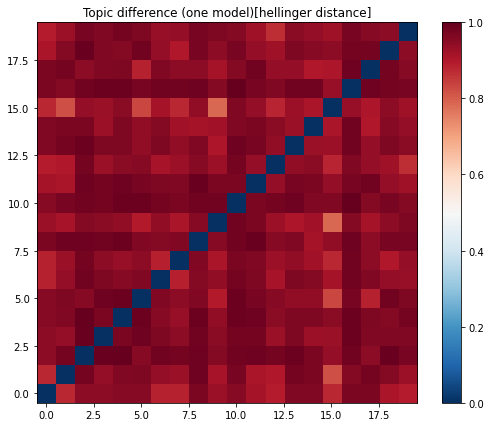

In [7]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(9, 7))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

mdiff, annotation = model.diff(model, distance='hellinger', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model)[hellinger distance]", annotation=annotation)

### Topic visualization

We can now proceed to visualize our results

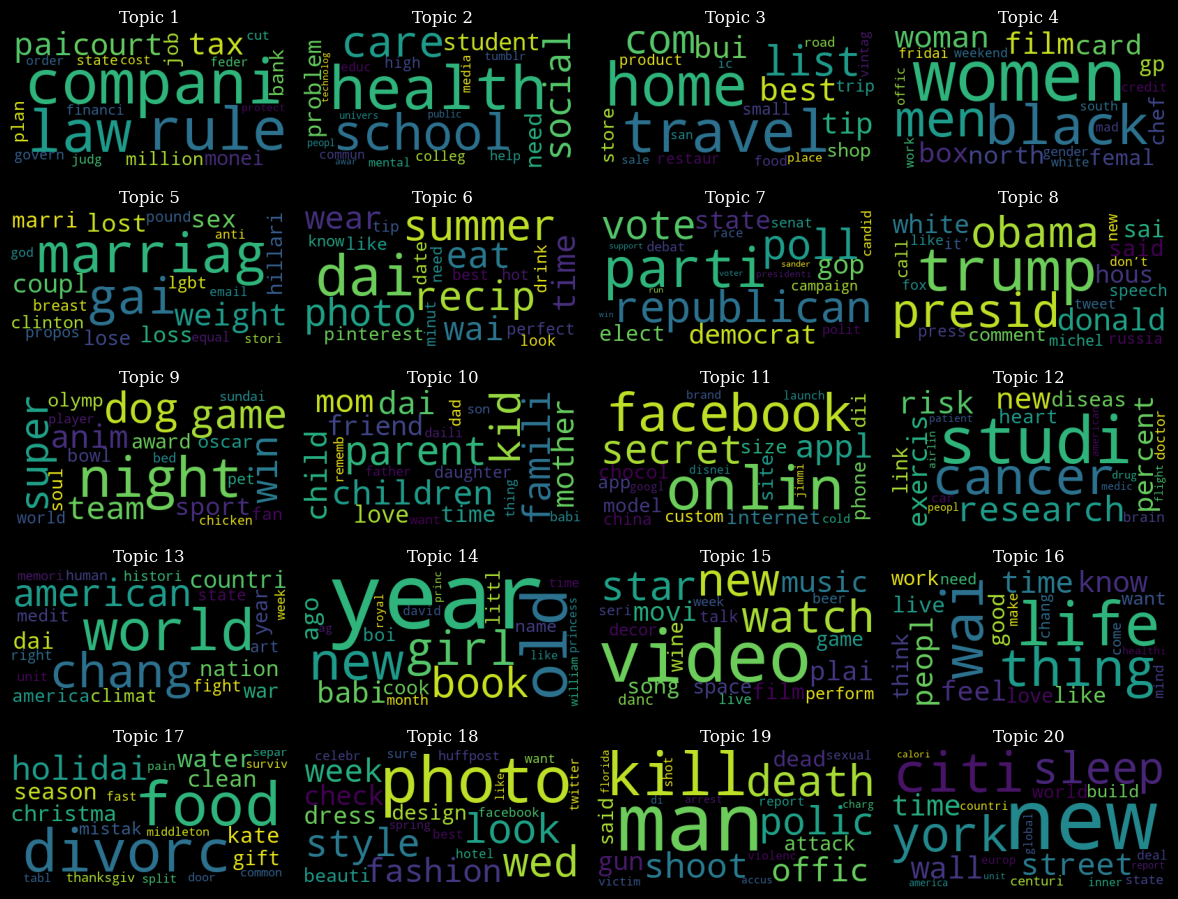

In [15]:
plt.rcParams["font.family"] = "serif"
plot_scale = 0.66

fig, axs = plt.subplots(ncols=4, 
                        nrows=int(n_topics/4), 
                        figsize=(18*plot_scale,14*plot_scale), 
                        dpi = 100, 
                        facecolor = 'black')
axs = axs.flatten() # for easer iteration
 
# fig.suptitle('Topic modeling from HuffPost dataset', color = 'white', fontsize=16)     

for i in range(n_topics):
    axs[i].set_title('Topic '+ str(i+1), color = 'white')
    mat = WordCloud(background_color='black', 
                    # colormap = 'jet',
                    random_state=5).generate_from_frequencies(dict(model.show_topic(i, 20)))
    axs[i].imshow(mat)
    axs[i].axis('off')
   
plt.tight_layout()